generating training toy set
gFM with diag-zero
ite=0(+0), trainset predict error= 0.845986, testset predict error=0.875371, 
ite=1(+3), trainset predict error= 0.293647, testset predict error=0.288972, 
ite=2(+3), trainset predict error= 0.287862, testset predict error=0.284305, 
ite=3(+3), trainset predict error= 0.287796, testset predict error=0.284264, 
ite=4(+4), trainset predict error= 0.287796, testset predict error=0.284265, 
ite=5(+3), trainset predict error= 0.287796, testset predict error=0.284265, 
ite=6(+3), trainset predict error= 0.287796, testset predict error=0.284265, 
stop initialzation
ite=7(+3), trainset predict error= 0.287796, testset predict error=0.284265, 
ite=8(+3), trainset predict error= 0.028211, testset predict error=0.0262639, 
ite=9(+3), trainset predict error= 0.00423258, testset predict error=0.00376559, 
ite=10(+4), trainset predict error= 0.000417425, testset predict error=0.000362702, 
ite=11(+3), trainset predict error= 7.88342e-05, testset predict

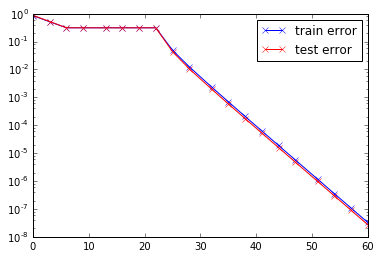

In [6]:
%matplotlib inline

import numpy
import os
import sys
import matplotlib.pyplot as plt
import scipy.sparse
import sklearn.metrics
import distutils.dir_util

sys.path.append('../')
import gFM


repeat_times = 1 # repeat experiments
dim = 100 # the dimension of features
rank_k = 3 # the rank of gFM
total_iteration = 60 # number of iterations to train gFM
total_record = 20 # number of check points
max_init_iter = 20 # number of iterations to initialize gFM

# We save the recovery error, training set prection error and testing set prediction error along iteration
trainset_error_record = numpy.zeros((repeat_times, total_record))
testset_error_record = numpy.zeros((repeat_times, total_record))
# The count of iteration at each check point
record_iteration_axis = numpy.round(numpy.linspace(0, total_iteration, total_record, endpoint=True)).astype('int')


X = numpy.random.randn(n_trainset, dim) # training set instances
X = numpy.sign(X)
X_test = numpy.random.randn(n_testset, dim) # testing set instances
X_test = numpy.sign(X_test)

# ground-truth gFM model
U_true = numpy.random.randn(dim, rank_k) / numpy.sqrt(dim)
w_true = numpy.random.randn(dim, 1) / numpy.sqrt(dim)

# generate true labels for training
y = (X.dot(w_true) + gFM.A_diag0(U_true, U_true, X.T)-0.5).flatten()

# generate true labels for testing
y_test = (X_test.dot(w_true) + gFM.A_diag0(U_true, U_true, X_test.T) - 0.5).flatten()

for repeat_count in xrange(repeat_times):
    print 'generating training toy set'
    n_trainset = 20 * rank_k * dim # size of training set
    n_testset = 10000 # size of testing set

    # Initialize gFM BatchRegression. We set max_init_iter=20 steps in the initialization with accuracy init_tol=1e-3.
    # In the training stage, we require to iterate as long as we want, so we set the training accuracy tol=0.
    # The learning rate is set to 1.
    # We can set the learning_rate to a small number e.g. learning_rate=0.1 when the data is not well conditioned.
    the_estimator = gFM.BatchRegression(rank_k=rank_k, max_init_iter=max_init_iter, learning_rate=1, init_tol=1e-4, tol=0, diag_zero=True)

    # Initialize gFM with no iteration. This will assign memory space for U,V,w without iteration.
    the_estimator.fit(X, y, n_more_iter=0)
    record_count = 0
    n_more_iter = 0
    y_trainset_pred = the_estimator.decision_function(X)
    y_testset_pred = the_estimator.decision_function(X_test)
    trainset_error = sklearn.metrics.mean_absolute_error(y, y_trainset_pred) / sklearn.metrics.mean_absolute_error(y, numpy.zeros((len(y),)))
    testset_error = sklearn.metrics.mean_absolute_error(y_test, y_testset_pred) / sklearn.metrics.mean_absolute_error(y_test, numpy.zeros((len(y_test),)))
    trainset_error_record[repeat_count, record_count] = trainset_error
    testset_error_record[repeat_count, record_count] = testset_error

    print 'ite=%d(+%d), trainset predict error= %g, testset predict error=%g, ' % \
          (record_count, n_more_iter, trainset_error, testset_error,)

    # start iteration
    for record_count in xrange(1, total_record):
        n_more_iter = record_iteration_axis[record_count] - record_iteration_axis[record_count - 1]
        # In each fit() call, we limite the number of iteration to be n_more_iter=n_more_iter.
        the_estimator.fit(X, y, n_more_iter=n_more_iter)
        y_trainset_pred = the_estimator.predict(X)
        y_testset_pred = the_estimator.predict(X_test)
        trainset_error = sklearn.metrics.mean_absolute_error(y, y_trainset_pred) / sklearn.metrics.mean_absolute_error(y, numpy.zeros((len(y),)))
        testset_error = sklearn.metrics.mean_absolute_error(y_test, y_testset_pred) / sklearn.metrics.mean_absolute_error(y_test, numpy.zeros((len(y_test),)))
        trainset_error_record[repeat_count, record_count] = trainset_error
        testset_error_record[repeat_count, record_count] = testset_error
        print 'ite=%d(+%d), trainset predict error= %g, testset predict error=%g, ' % \
              (record_count, n_more_iter, trainset_error, testset_error,)

    the_results = numpy.load(export_filename)
    record_iteration_axis = the_results['record_iteration_axis']

    trainset_error_record = the_results['trainset_error_record']
    testset_error_record = the_results['testset_error_record']

    # plot curves
    export_figname = './gFM_BatchReg_diag0_prediction_error_curve.png'
    plt.semilogy(record_iteration_axis, numpy.mean(trainset_error_record, axis=0), '-xb', label='train error')
    plt.semilogy(record_iteration_axis, numpy.mean(testset_error_record, axis=0), '-xr', label='test error')
    plt.legend()
    plt.savefig(export_figname)
    plt.show()